In [198]:
import sys

import numpy as np
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import psycopg2
from shapely.geometry import LineString, Polygon, Point
from shapely import wkt
import mplleaflet
from tqdm import tqdm
import geojson
import json
from sklearn.metrics import recall_score, average_precision_score, precision_recall_curve
from inspect import signature


In [199]:
roads_df0 = pd.read_csv('roads_exp0_wpavref.csv')
roads_df1 = pd.read_csv('roads_exp1_wpavref.csv')
roads_df2 = pd.read_csv('roads_exp2_wpavref.csv')
roads_df3 = pd.read_csv('roads_exp3_wpavref.csv')
roads_df = pd.concat([roads_df0,roads_df1,roads_df2,roads_df3],sort=False)

In [200]:
roads_df['geometry'] = roads_df.geometry.apply(wkt.loads)
roads_gdf = gp.GeoDataFrame(roads_df, geometry='geometry')

In [201]:
acc_df = roads_gdf[roads_gdf.nacc > 0]
acc_df = acc_df.loc[acc_df.index.repeat(acc_df['nacc'])]
acc_df.loc[:]['nacc'] = 1

In [202]:
noacc_df = roads_gdf[roads_gdf.nacc == 0]
sampled_noacc_df = noacc_df.sample(20000)

In [203]:
comb_df = pd.concat([acc_df,sampled_noacc_df])

In [204]:
import sklearn.model_selection
from sklearn import linear_model, model_selection
X = comb_df[['nlanes','speed_lim']]
#X = comb_wlanes[['speed_lim']]
y = comb_df[['nacc']]

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X,y, test_size=0.2,shuffle=True)

In [205]:
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train, y_train)

/Users/karlen/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7305745380916224 0.6146179401993356 0.6793229397825625


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.68')

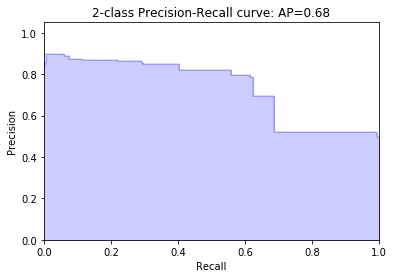

In [206]:
print(clf.score(X_valid,y_valid), recall_score(y_valid,clf.predict(X_valid)),average_precision_score(y_valid,clf.predict(X_valid)))
y_score = clf.decision_function(X_valid)
precision, recall, _ = precision_recall_curve(y_valid, y_score)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision_score(y_valid,clf.predict(X_valid))))

(array([10464.,  1428., 81862., 17413.,  1530.,  4725.,  8905.,  4279.,
         5661.,  3282.]),
 array([0.06013633, 0.15330613, 0.24647593, 0.33964573, 0.43281554,
        0.52598534, 0.61915514, 0.71232494, 0.80549474, 0.89866454,
        0.99183434]),
 <a list of 10 Patch objects>)

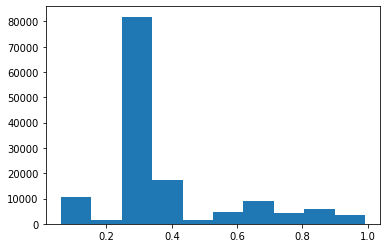

In [209]:
probs = clf.predict_proba(roads_gdf[['nlanes','speed_lim']])

acc_prob = [p[1] for p in probs]
roads_gdf['acc_prob'] = acc_prob
plt.hist(acc_prob)

Text(0.5, 1.0, 'Logistic regression coefficients')

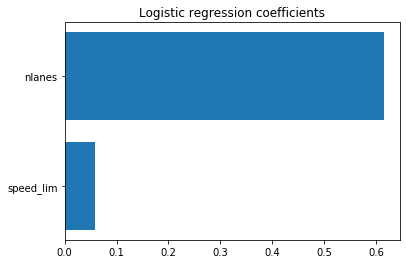

In [208]:
plt.barh(range(len(clf.coef_[0])),
         width=np.sort(clf.coef_[0]))
plt.yticks(ticks=range(len(clf.coef_[0])), labels=X.columns[np.argsort(clf.coef_[0])])
plt.title('Logistic regression coefficients')

In [57]:
def data2geojson(df,filename='acc_layer3.geojson'):
    features = []
    
    insert_features = lambda X: features.append(            
            geojson.Feature(geometry=X['geometry'],
                            properties={'acc_prob': X['acc_prob']}))
    
    df.apply(insert_features, axis=1)
    with open(filename, 'w', encoding='utf8') as fp:
        geojson.dump(geojson.FeatureCollection(features), fp, sort_keys=True, ensure_ascii=False)

layer = roads_gdf[['acc_prob','geometry']]

data2geojson(layer)

In [212]:
df0 = pd.read_csv('roads_exp0.csv')
df1 = pd.read_csv('roads_exp1.csv')
df2 = pd.read_csv('roads_exp2.csv')
df3 = pd.read_csv('roads_exp3.csv')
df_all = pd.concat([df0,df1,df2,df3],sort=False)
#df_all = df0
df_all['geometry'] = df_all.geometry.apply(wkt.loads)
pdf_all = gp.GeoDataFrame(df_all, geometry='geometry')

In [213]:
probs_all = clf.predict_proba(pdf_all[['nlanes','speed_lim']])
acc_prob_all = [p[1] for p in probs_all]

In [214]:
def applyrule(df,rule,penalty):
    df.loc[rule,['acc_prob']] = df.loc[rule].acc_prob + penalty

def sendrules(df):
    applyrule(df, df.speed_lim > 35, 0.2)
    applyrule(df, df.speed_lim > 30, 0.1)
    applyrule(df, df.speed_lim > 25, 0.05)
    applyrule(df, df.nacc > 0, 0.1)
    applyrule(df, df.nacc > 1, 0.2)
    applyrule(df, df.highway == 'cycleway', -0.4)
    applyrule(df, df.bicycle == 'designated', -0.4)
    applyrule(df, (df.bicycle == 'yes') | (df.bicycle == 'permissive'), - 0.1)

pdf_all['acc_prob'] = acc_prob_all
pdf_all['acc_prob2'] = acc_prob_all
sendrules(pdf_all)
pdf_all.loc[pdf_all.acc_prob < 0,['acc_prob']] = 0
pdf_all.loc[pdf_all.acc_prob > 1,['acc_prob']] = 1

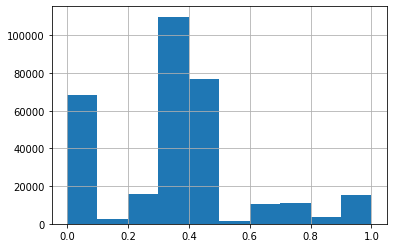

In [231]:
pdf_all.acc_prob.hist()
geom = pdf_all.geometry

def crop_roads(l,p):
    return l.within(p)

SW = [33.930416, -118.539958]
NE = [34.158886, -118.201925]
meshy = np.linspace(SW[0],NE[0],3)
meshx = np.linspace(SW[1],NE[1],3)
polybl = [(meshx[0],meshy[0]),(meshx[0],meshy[1]),(meshx[1],meshy[1]),(meshx[1],meshy[0]),(meshx[0],meshy[0])] #bot left

In [233]:
poly = Polygon(polybl)
keep = []

for row in geom:
    keep.append(crop_roads(row,poly))

In [234]:
pdf_all = pdf_all[keep]

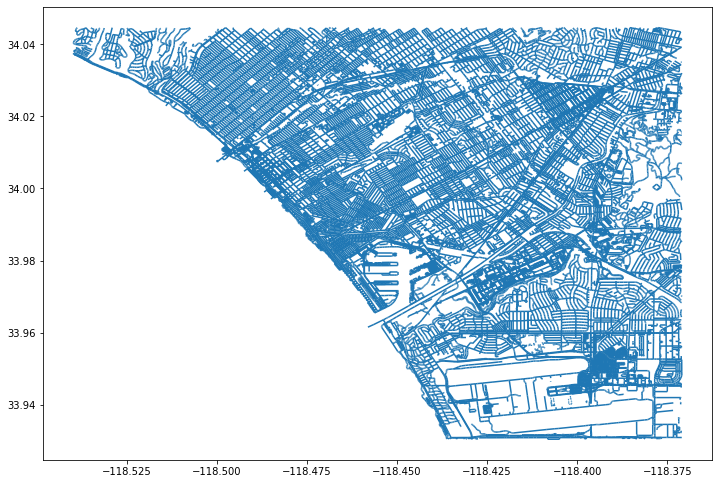

In [238]:
pdf_all.plot(figsize=(12,12))

In [239]:
layer_all = pdf_all[['acc_prob','geometry']]
data2geojson(layer_all,filename='acc_layer_bl.geojson')

In [111]:
np.size(np.where(pdf_all.nacc[pdf_all.bicycle=='permissive']!=0)[0]) / np.size(np.where(pdf_all.nacc[pdf_all.bicycle=='permissive']==0)[0])

0.12

In [132]:
pdf_all[pdf_all.highway=='pedestrian'].shape[0]/pdf_all.shape[0]

0.0031753282388506643

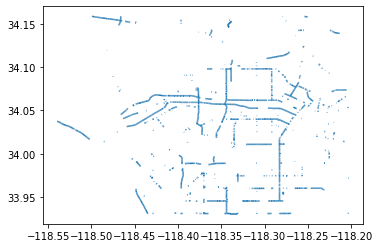

In [149]:
pdf_all[pdf_all.acc_prob2 >0.9].plot()